In [2]:
#############################################################################################################################################
######~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PRUEBA CIENTIFICO DE DATOS NEQUI ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  ########

* Importo librerias requeridas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
from scipy.stats import chi2_contingency
%matplotlib inline
import os
import glob as glob
import scipy
import statsmodels.formula.api as smf
import pingouin as pg
from sklearn.metrics import mean_absolute_error

c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
files = glob.glob(r"D:\Desktop\DataNequi\*.parquet")
 ## Trabajo sólo con archivos por capacidad computacional

In [4]:
files=files[:3]

In [5]:
df = pd.DataFrame()
for f in files:
    appenddata = pd.read_parquet(f)
    appenddata['filename'] = os.path.basename(f)
    appenddata.columns = map(str.lower, appenddata.columns)
    df = df.append(appenddata,ignore_index=True)
df.drop(df.filter(like='unname').columns,axis=1,inplace=True)

### Problema a resolver
* Paso 1: Alcance del proyecto.
* El objetivo de la prueba es idear una solución para identificar transacciones que evidencian un
comportamiento de Mala Practica Transaccional, empleando un producto de datos.

* Adicional, describir la solución y **detallar** cómo incorporar el producto de datos en un marco
operativo.

* Una Mala Practica Transaccional es un comportamiento donde se evidencia un uso de los 
canales mal intencionado, para la prueba técnica nos centraremos en la práctica de
Fraccionamiento Transaccional, esta mala práctica consiste en fraccionar una transacción en un
número mayor de transacciones con menor monto que agrupadas suman el valor de la
transacción original.

* Estas transacciones se caracterizan por estar en una misma ventana de
tiempo que suele ser 24 horas y tienen como origen o destino la misma cuenta o cliente.

* Con la solución de este reto, esperamos conocer las habilidades de modelado estadístico,
matemático, heurístico y/o analítico en general que a lo largo de su vida académica y
profesional han desarrollado.

* Valoramos mucho la habilidad que tengan de detallar los hallazgos dados a partir de las
diferentes etapas del análisis.

### Variables
* _id: Identificador único del registro
* merchant_id: Código único del Comercio o aliado.
* subsidiary: Código unico de la sede o sucursal.
* transaction_date: Fecha de contabilización de la transacción en el core Financiero.
* account_number: numero único de cuenta
* user_id: Código único del usuario dueño de la cuenta desde donde se registran las
* transacciones.
* transaction_amount: Monto de la transaction en moneda ficticia.
* transaction_type: Naturaleza de la transacción valores (DEBITO o CREDITO)

In [ ]:
## parse dates
df['transaction_date']=pd.to_datetime(df['transaction_date'],format="%Y-%m-%d %H:%M:%S")
df['transaction_amount']=df['transaction_amount'].astype(float)

* Se hallan duplicados en la data, por tanto, se eliminan duplicados por el identidicador único.

In [ ]:
df=df[~df['_id'].duplicated(keep='last')]

* **!Ojo!** se descubre que hay cuentas con el mismo número y el mismo user_id muy cercanas en fechas pero que difieren en el medio de transacción.

In [ ]:
a=df.groupby(['subsidiary','account_number','user_id']).agg({'transaction_amount':'sum','transaction_type':'nunique'}).reset_index()
df['key']=df['subsidiary'].astype(str)+"_"+df['account_number'].astype(str)+"_"+df['user_id'].astype(str)
a['key']=a['subsidiary'].astype(str)+"_"+a['account_number'].astype(str)+"_"+a['user_id'].astype(str)
print(a[a['transaction_type']>1].shape[0],"Cantidad de transacciones que califico como anomalas dado que tienen el mismo tipo de cuenta credito y debito")
#### Se eliminan dichos casos y dado que no se sabe si es credito o debito y puede generar ruido al análisis.
a=a[(a['transaction_type']>1)]
df=df[~df['key'].isin(a['key'])]

333681 Cantidad de transacciones que califico como anomalas dado que tienen el mismo tipo de cuenta credito y debito


### Validación de variables de la Base de datos

In [ ]:
print("Cantidad de Comercios aliados\n",df['merchant_id'].nunique(),)
print("Cantidad de sedes unicas\n",df['subsidiary'].nunique())
print("Cantidad de numeros único de cuentas\n",df['account_number'].nunique())
print("Cantidad por tipo de transacción\n",df['transaction_type'].value_counts())
print("Cantidad de numero único de usuario",df['user_id'].nunique())

Cantidad de Comercios aliados
 3
Cantidad de sedes unicas
 17095
Cantidad de numeros único de cuentas
 3895647
Cantidad por tipo de transacción
 DEBITO     23974935
CREDITO     5033133
Name: transaction_type, dtype: int64
Cantidad de numero único de usuario 3876476


In [ ]:
### Se ordena la Base de datos por los siguientes campos
df=df.sort_values(by=['subsidiary','account_number', 'user_id','transaction_date'])#.agg({'_id':'nunique'})

In [ ]:
### ¿cuantas sedes unicas se encuentran aliadas a acada comercio aliado?
df.groupby(['merchant_id']).agg({'subsidiary':'nunique'}).style.background_gradient(cmap='Blues').format("{:.0f}")

,subsidiary
merchant_id,
075d178871d8d48502bf1f54887e52fe,4208
817d18cd3c31e40e9bff0566baae7758,5240
838a8fa992a4aa2fb5a0cf8b15b63755,7647


* Se planea identificar la cantidad de transacciones mensuales(con y sin fraccionamiento) de manera mensual, con el fin de conocer el comportamiento normal de la serie de tiempo.

In [11]:
### Cantidad de transacciones mensuales
R_daily_1=df.groupby([pd.Grouper(key='transaction_date',freq='M')]).agg({'_id':'nunique'}).rename(columns={'_id':'cantidad'})

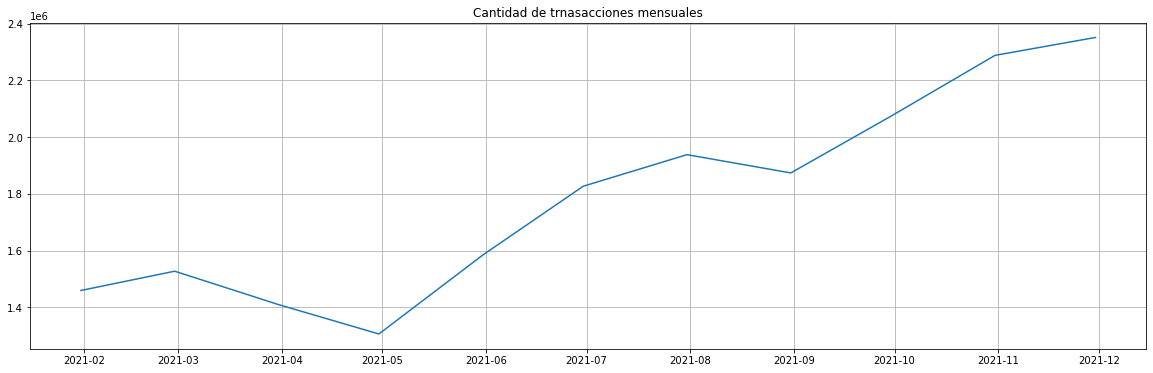

In [11]:
plt.figure(figsize=(20, 6))
plt.plot(R_daily_1.cantidad)
plt.title('Cantidad de trnasacciones mensuales')
plt.grid(True)
plt.show()

* Cantidad de transacciones de forma mensual en todo el año 2021 con la Bd (con y sin transacciones fraccionadas)

In [12]:
R_daily_1

,cantidad
transaction_date,
2021-01-31,1459233
2021-02-28,1527194
2021-03-31,1409462
2021-04-30,1305784
2021-05-31,1584091
2021-06-30,1826833
2021-07-31,1938286
2021-08-31,1873830
2021-09-30,2074514


* Distirbución de la cantidad de transacciones

<AxesSubplot:>

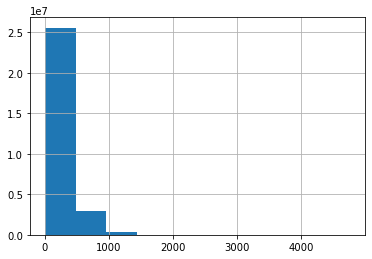

In [11]:
df.transaction_amount.hist()

In [12]:
df.transaction_amount.describe()

count    2.900807e+07
mean     1.989557e+02
std      2.432751e+02
min      5.944455e+00
25%      4.755564e+01
50%      1.188891e+02
75%      2.377782e+02
max      4.755564e+03
Name: transaction_amount, dtype: float64

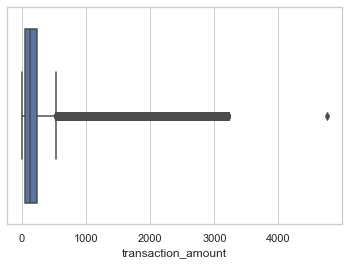

In [13]:
df['transaction_amount']=df['transaction_amount'].astype(float)
### Muchso valores extremos considerados atipicos, en dichos montos apriori no hay fraccionamiento
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df['transaction_amount'])

In [16]:
#a=df.sample(1000000)
# Se palaneaba jecutarpra hallar los natural breaks pero computacionalmente es costoso
#import jenkspy
#breaks = jenkspy.jenks_breaks(a['transaction_amount'], nb_class=5)
#pd.cut(a['transaction_amount'],
#                        bins=breaks)

In [17]:
breaks=[0,250,500,750,4000]
#breaks = jenkspy.jenks_breaks(df['transaction_amount'], nb_class=5)
df['cut_jenks'] = pd.cut(df['transaction_amount'],
                        bins=breaks )

<AxesSubplot:>

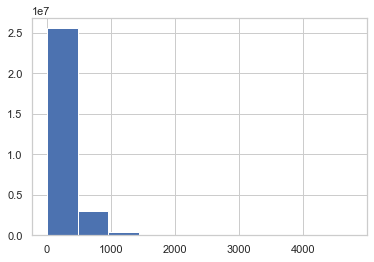

In [14]:
df['transaction_amount'].hist()

* Bineado de variables para identificar la proporción por rango

In [19]:
df['cut_jenks'].value_counts(True)*100

(0, 250]       76.281115
(250, 500]     12.305179
(500, 750]      9.185379
(750, 4000]     2.228327
Name: cut_jenks, dtype: float64

c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


La cantidad de transacciones por monto se centra en su mayoria en todos los bins en el tipo de transacción debito


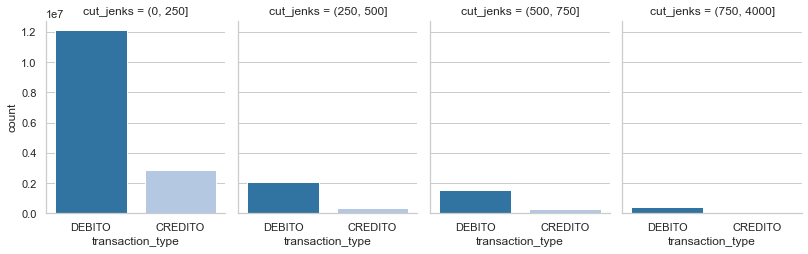

In [20]:
g = sns.catplot("transaction_type", col="cut_jenks", col_wrap=4,
                data=df,
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')
print("La cantidad de transacciones por monto se centra en su mayoria en todos los bins en el tipo de transacción debito")

In [15]:
df['transaction_type'].value_counts(True)

DEBITO     0.826492
CREDITO    0.173508
Name: transaction_type, dtype: float64

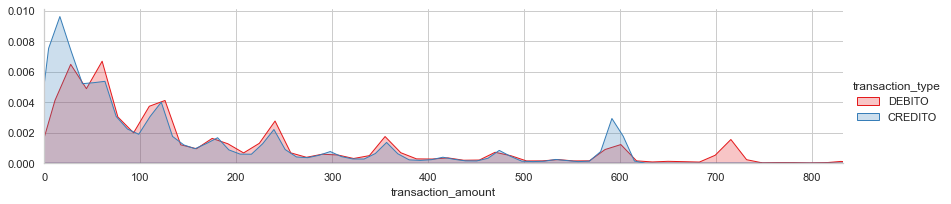

In [26]:
a = sns.FacetGrid(df, hue = 'transaction_type', aspect=4, palette="Set1" )
a.map(sns.kdeplot, 'transaction_amount', shade= True )
a.set(xlim=(0 , df['transaction_amount'].quantile(0.98)))
a.add_legend()
# La distribución de ambas transacciones se solapan el creidto es más usado para montos bajos

* Cantidad de sucursales. Top 10 con más transacciones.

In [16]:
df1=df.groupby(['subsidiary']).agg({'_id':'nunique'}).rename(columns={'_id':'cantidad'}).sort_values(['cantidad'],ascending=False).head(10)
#df1.style.background_gradient(cmap='Blues',axis = 0).format("{:.0f}")

In [17]:
df1.reset_index(inplace=True)

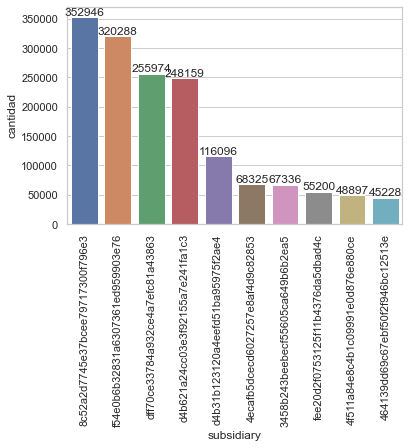

In [18]:
ax=sns.barplot(x=df1.subsidiary, y=df1.cantidad)
plt.xticks(rotation=90)
for i in ax.containers:
    ax.bar_label(i,)

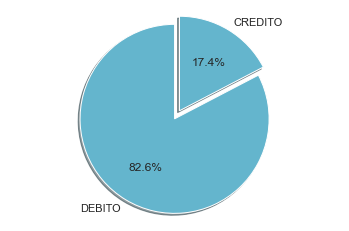

In [19]:
#import plotly.express as px
fig1, ax1 = plt.subplots()
explode = (0, 0.1)
labels=['DEBITO','CREDITO']
ax1.pie(df['transaction_type'].value_counts(), explode=explode, labels=labels,autopct='%1.1f%%',
        shadow=True, startangle=90,colors='c')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [20]:
### Grafico por mes ### 
df['mes']=df['transaction_date'].dt.month

* Pruebas de independencia
* las dos medias de población son iguales Ho
* Ha las medias son diferentes

In [21]:
### Las muestras son independientes al rechazar la hipotesis nula
print(scipy.stats.ttest_ind(df[df['transaction_type']=='DEBITO']['transaction_amount'], df[df['transaction_type']=='CREDITO']['transaction_amount'], axis=0, equal_var= False))
print('Se concluye que los datos no están relacionados al rechazar H0')

Ttest_indResult(statistic=678.8876065010049, pvalue=0.0)
Se concluye que los datos no están relacionados al rechazar H0


In [22]:
# Test para datos independientes (p-value, intervalos de confianza)
deb = df.loc[df.transaction_type == 'DEBITO', 'transaction_amount']
cre = df.loc[df.transaction_type == 'CREDITO', 'transaction_amount']
pg.ttest(x=deb, y=cre, paired=False, tail='two-sided')

c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\pingouin\bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,678.887607,1.043638e+07,two-sided,0.0,"[62.13, 62.49]",0.257334,inf,1.0


* Dado que p-value (0.0) es mayor que el nivel de significancia alpha (0.05) , se dispone de evidencia suficiente para considerar que existe una diferencia real entre el monto de las transacciones promedio de transacciones debito versos las transacciones via credito.
* cohen-d El promedio del monto del debito es 0.278282 desviaciones estandar más grandes que el promedio del credito

In [23]:
tabla_chi=pd.crosstab(df['transaction_type'],df['merchant_id'])
stat, p, dof, expected = chi2_contingency(tabla_chi)
print(p,'Se concluye que los datos no están relacionados al rechazar H0, pueden ser utiles como varaibels predictoras')

0.0 Se concluye que los datos no están relacionados al rechazar H0, pueden ser utiles como varaibels predictoras


La prueba de independencia Chi cuadrado permite evaluar la siguientes hipótesis nulas y alternativa: H0 : χ 2 = 0 No existe asociación entre las variables. H1 : χ 2 > 0. Hay asociación entre las variables.

In [24]:
tabla_chi=pd.crosstab(df['transaction_type'],df['merchant_id']).values
X2 = chi2_contingency(tabla_chi, correction=False)[0]
n = np.sum(tabla_chi)
mDim = min(tabla_chi.shape)-1
V = np.sqrt((X2/n) / mDim)
print(V,'Se concluye que los datos están relacionados al ACEPTAR H0 (No hay diferencia entre las distribuciones) usando cramer dado que hay una fuerte asociación entre variables')
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

0.75141836470424 Se concluye que los datos están relacionados al ACEPTAR H0 (No hay diferencia entre las distribuciones) usando cramer dado que hay una fuerte asociación entre variables


In [25]:
### Rango de las fechas usadas para el estudio
print("Fecha minima",df.transaction_date.min())
print("Fecha maxima",df.transaction_date.max())

Fecha minima 2021-01-01 00:00:02
Fecha maxima 2021-11-30 23:59:53


* Quiero observar como se han comportado la cantidad de tranasacciones por día para identificar algún dato atipico de forma grafica

In [26]:
#R_daily_1=df.groupby([pd.Grouper(key='transaction_date',freq='d')]).agg({'_id':'nunique'})

In [27]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, 
                      plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "black", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [28]:
#plotMovingAverage(R_daily_1, 15)

In [29]:
#plotMovingAverage(R_daily_1, 15, plot_intervals=True, plot_anomalies=True)

In [30]:
R_daily_1.rename(columns={'_id':'cantidad'},inplace=True)

NameError: name 'R_daily_1' is not defined

#### Grado de dispersión dado la cantidad de transacciones en el año 2021

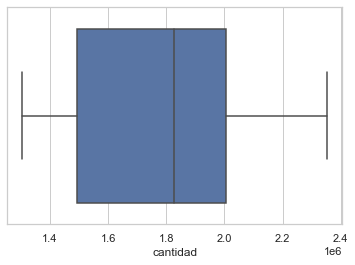

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=R_daily_1['cantidad'])

In [31]:
rs=df.groupby(['merchant_id','subsidiary','account_number','user_id',pd.Grouper(key='transaction_date',freq='24h')]).agg({'_id':'nunique'}).reset_index()
rs.rename(columns={'_id':'cantidad'},inplace=True)

In [32]:
print((rs[rs.cantidad>rs.cantidad.quantile(0.9)].shape[0]/rs.shape[0])*100,"Cantidad de transacciones fraccionadas percentil 90")
print(rs['cantidad'].describe(),"\n Hay transacciones con maximos de 200 fracionamientos del monto\n original lo que hace que se cree una cola a la derecha y que la distribuicón sea asimetrica positiva")

6.596753336066243 Cantidad de transacciones fraccionadas percentil 90
count    2.677000e+07
mean     1.083604e+00
std      6.032263e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.000000e+02
Name: cantidad, dtype: float64 
 Hay transacciones con maximos de 200 fracionamientos del monto
 original lo que hace que se cree una cola a la derecha y que la distribuicón sea asimetrica positiva


In [33]:
rs.head(1)

,merchant_id,subsidiary,account_number,user_id,transaction_date,cantidad
0,075d178871d8d48502bf1f54887e52fe,00015fd77a0f4d869bea31bb7244e375,008781cdeca5a4a1b1a33965b59073b0,05c3431a00c6be98032ce7c6dcf88277,2021-06-15,1


* Cantidad de transacciones realizadas el mismo dia sobre  el mismo account_number y user_id

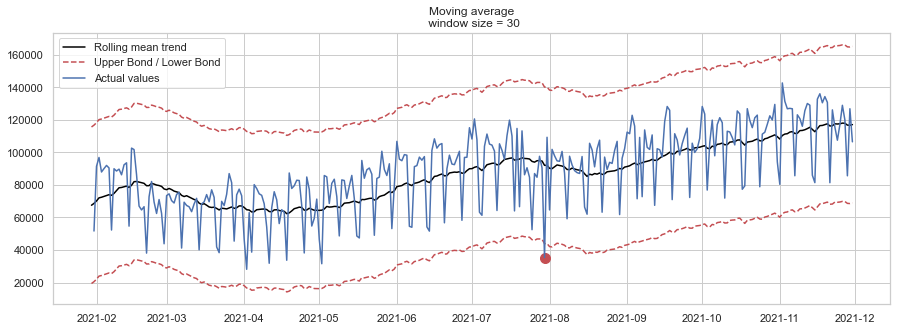

In [34]:
rs1=rs.groupby(['transaction_date']).agg({'cantidad':sum})
plotMovingAverage(rs1, 30,plot_anomalies=True,plot_intervals=True)

* Top 10 de la cantidad de fraccionamientos historica.

In [35]:
#df[(df['merchant_id']=='838a8fa992a4aa2fb5a0cf8b15b63755') & (df['subsidiary']=='d4b621a24cc03e3f92155a7e241fa1c3') & (df['account_number']=='d772a45895d6641c627e30a675aee21d')& (df['user_id']=='23d70f5c4acc2584b7f4f25a3b777ec3')]

In [36]:
rs.sort_values(['cantidad'],ascending=False).head(10)

,merchant_id,subsidiary,account_number,user_id,transaction_date,cantidad
25986274,838a8fa992a4aa2fb5a0cf8b15b63755,d4b621a24cc03e3f92155a7e241fa1c3,fee8e926035eb3498989a933f209768d,8796988fe01305c7f63dedf306f8bc25,2021-02-15,300
26601028,838a8fa992a4aa2fb5a0cf8b15b63755,f54e0b6b32831a6307361ed959903e76,aa1e2635d20530ac465b5f674f5dcf51,71aa1651d9adc0b226107084fba3d71c,2021-01-03,300
24150212,838a8fa992a4aa2fb5a0cf8b15b63755,4f511a84e8c4b1c09991e0d876e880ce,aa1e2635d20530ac465b5f674f5dcf51,71aa1651d9adc0b226107084fba3d71c,2021-02-07,298
25968957,838a8fa992a4aa2fb5a0cf8b15b63755,d4b621a24cc03e3f92155a7e241fa1c3,e9271126f0a7db1ba4432d15ece2bbe2,dc07e2251a5c739844e664f4b13d1d85,2021-02-10,293
25925377,838a8fa992a4aa2fb5a0cf8b15b63755,d4b621a24cc03e3f92155a7e241fa1c3,b1cf592ec9c6611fa31c934c300edeab,36b40ee3eced5b254879f12b8c0a8fc6,2021-02-13,286
26601027,838a8fa992a4aa2fb5a0cf8b15b63755,f54e0b6b32831a6307361ed959903e76,aa1e2635d20530ac465b5f674f5dcf51,71aa1651d9adc0b226107084fba3d71c,2021-01-01,284
25875669,838a8fa992a4aa2fb5a0cf8b15b63755,d4b621a24cc03e3f92155a7e241fa1c3,73464f761ee152a51ad593c6bd534878,dc07e2251a5c739844e664f4b13d1d85,2021-02-12,269
25971677,838a8fa992a4aa2fb5a0cf8b15b63755,d4b621a24cc03e3f92155a7e241fa1c3,ec8fd57e920bad4effc420bb19d97306,33bce3d989db63d5ef6fa5382cb641f8,2021-02-02,256
26573896,838a8fa992a4aa2fb5a0cf8b15b63755,f54e0b6b32831a6307361ed959903e76,88ddd8992c68461c09c66cc46f60deeb,3b1495b6efe65276ea463c532ad28334,2021-01-22,229
25785681,838a8fa992a4aa2fb5a0cf8b15b63755,d4b621a24cc03e3f92155a7e241fa1c3,01a0e3245c86b13c1bc9b4d136476372,09ef9d0c0923b7f4848655f0de449603,2021-01-16,222


In [ ]:
del R_daily_1

In [37]:
df['hora']=df['transaction_date'].dt.hour
df['Dia Semana'] = df['transaction_date'].dt.day_name()
### Revalidación
df['_id'].nunique(),df.shape

(29008068, (29008068, 13))

In [38]:
## introudcir el mes a revisar
mes=11

Frecuencia de cada ua de las transacciones


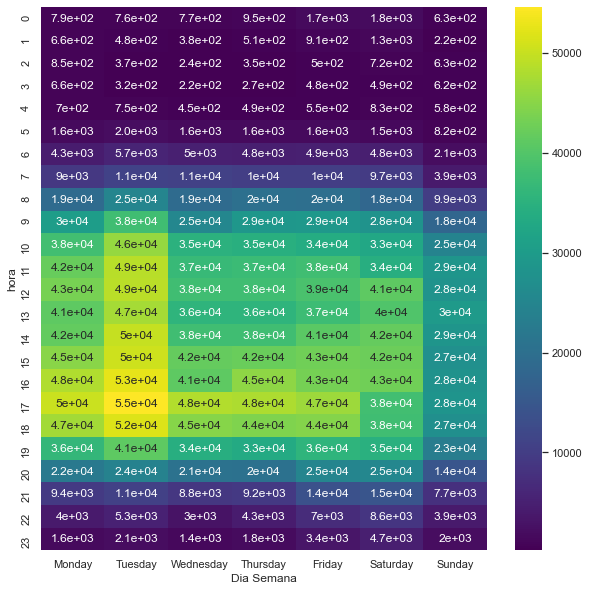

In [39]:
dense = df[df['mes']==mes].groupby(['hora', 'Dia Semana']).agg({'_id': 'count'}).reset_index()
vmin, vmax = dense['_id'].quantile([0, 1])
plt.figure(figsize = (10, 10))
sns.heatmap(dense.pivot(index = 'hora', columns = 'Dia Semana', values = '_id')[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']],
                                 annot = True, vmin = vmin, vmax = vmax, cmap = 'viridis')
print("Frecuencia de cada ua de las transacciones")

#### Creación de la variable Objetivo

In [40]:
############ Alternativas muy utiles para validación pero computacionalmente costosas       ########### 
#df2['diff']=df2.groupby(['subsidiary','account_number', 'user_id'])['transaction_date'].diff()
#df2['diff1']=df2.groupby(['subsidiary','account_number', 'user_id'])['transaction_date'].diff(periods=-1)

In [41]:
df['date']=pd.to_datetime(df['transaction_date'].astype(str).str.split(' ',expand=True)[0],format='%Y-%m-%d')
#df2[df2['key']=='00015fd77a0f4d869bea31bb7244e375_3d7f6df80d0ddd2039d6cbcf351cf5f4_9d01480f0d114d17c43839ea11a2b8c8']
df['seq']=df.sort_values(by=['subsidiary','account_number','user_id','transaction_date'], ascending=True).\
                     groupby(['subsidiary','account_number','user_id',pd.Grouper(key='transaction_date',freq='24h', origin='start')]).cumcount()+1
df['monto_real']=df.groupby(['subsidiary','account_number','user_id',pd.Grouper(key='transaction_date',freq='24h', origin='start')])['transaction_amount'].transform('sum')
df['fraccionamientos']=df.groupby(['subsidiary','account_number','user_id',pd.Grouper(key='transaction_date',freq='24h', origin='start')])['transaction_date'].transform('count')

In [42]:
df['ano_mes']=df['transaction_date'].astype(str).str[:7]
df['ano_mes']=pd.to_datetime(df['ano_mes'],format='%Y-%m',errors='coerce')
aux=df.groupby(['subsidiary','account_number','user_id','ano_mes'])['_id'].nunique().reset_index().sort_values(['subsidiary','account_number','user_id','ano_mes'],ascending=True).drop_duplicates(['subsidiary','account_number','user_id'],keep='last')
aux.rename(columns={'_id':'can_tran_ult_mes'},inplace=True)

In [43]:
#df[df['fraccionamientos']==2]
df['output']=np.where((df['fraccionamientos']>1),1,0)
#df['output2']=np.where((df['diff']<pd.to_timedelta('1 days 23:59:59')) | (df['diff']<pd.to_timedelta('-1 days 23:59:59')),1,0)
df['monto_fraccionamiento']=df['transaction_amount']/df['monto_real']

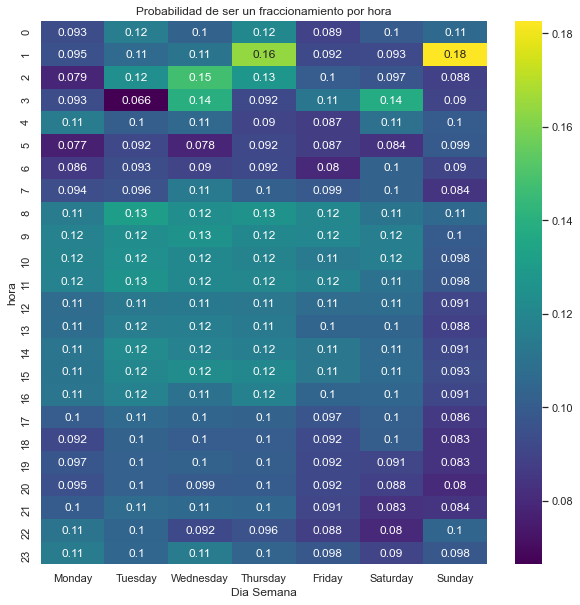

In [44]:
plt.figure(figsize = (10, 10))
dense_commitment = df[(df['output'] == 1) & (df['mes']==mes)]
dense_commitment = dense_commitment.groupby(['hora', 'Dia Semana']).agg({'_id': 'count'}).reset_index()
# dense_commitment.reset_index(drop=True,inplace=True)
dense_commitment.reset_index().pivot(index = 'hora', columns = 'Dia Semana', values = '_id')[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']] 
sns.heatmap(dense_commitment.pivot(index = 'hora', columns = 'Dia Semana', values = '_id')[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']] / dense.pivot(index = 'hora', columns = 'Dia Semana', values = '_id')[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']], annot = True, cmap = 'viridis')
plt.title('Probabilidad de ser un fraccionamiento por hora');

In [45]:
pg.ttest(df.loc[df['output']==1, 'transaction_amount'],
 df.loc[df['output']==0, 'transaction_amount'])
## ttest
# Se rechaza h0 y se concluye que las variables son independientes y posiblemente dicha variable va a ser importante para el modelo

c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\pingouin\bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,848.086059,4.585074e+06,two-sided,0.0,"[144.76, 145.44]",0.609482,inf,1.0


In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.boxplot(y="output", x="transaction_amount", data=df, ax=ax)
sns.swarmplot(y="output", x="transaction_amount", data=df, color='black', alpha = 0.5, ax=ax);

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000000000B580558> (for post_execute):


KeyboardInterrupt: 

In [47]:
df['cant_tran_hist_diff_cuentas']=df.groupby(['account_number'])['user_id'].transform('nunique')
df['cant_meses_con_tran']=df.groupby(['subsidiary','account_number','user_id'])['ano_mes'].transform('nunique')
df['trans_mes']=df.groupby(['subsidiary','account_number','user_id','mes'])['transaction_amount'].transform('mean')
#df['cut_jenks']=df['cut_jenks'].astype(str)

In [48]:
df.drop(['_id','subsidiary','account_number','user_id','key','filename','ano_mes','mes','date'],axis=1,inplace=True)

In [49]:
del dense, aux,dense_commitment

In [51]:
df.drop(['transaction_date','Dia Semana','monto_real'],axis=1,inplace=True)

In [52]:
del  rs1,rs

In [53]:
## Limpieza de outliers
q_uno=df['transaction_amount'].quantile(0.99)
df['transaction_amount']= np.where(df['transaction_amount'] > q_uno, q_uno ,df['transaction_amount'])

* Se comienza a tratar la información de cara al inicio de la modelación y despúes de crear algunas variables (aunque algunas se encuentra correlacionadas y no es necesario incluirlas dado que su relación linean con otra variable puede capturar ese movimiento y se trata de evitar una posible multicolinealidad).

In [54]:
types = pd.DataFrame(df.dtypes)
print("Tipos de variables", types.groupby(0).size())

consolidado =df[:3000000].reset_index(drop=True)#replace({False: 0, True: 1})

types = pd.DataFrame(consolidado.dtypes)
print("Tipos de variables luego de reemplazo",types.groupby(0).size())

Tipos de variables 0
int32      1
int64      5
float64    3
object     2
dtype: int64
Tipos de variables luego de reemplazo 0
int32      1
int64      5
float64    3
object     2
dtype: int64


In [55]:
categoricas = types.index[types[0] == 'O'].values
for line in categoricas:
 print("La variable "+ line +" contiene:",str(len(df[line].unique()))+" distinct values")

La variable merchant_id contiene: 3 distinct values
La variable transaction_type contiene: 2 distinct values


In [56]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [57]:
#Se define función que captura el dataframe y la columna para retornar un dataframe luego de OHE
def crea_OneHotEncoding(df, columna):
  le = LabelEncoder()
  le_ajustado=le.fit_transform(df[columna]).reshape(-1,1)
  encoder = OneHotEncoder(sparse=False)
  column = [columna+ "_"+ str(i) for i in le.classes_]
  data = encoder.fit_transform(le_ajustado)
  return(pd.DataFrame(data,columns =column))

In [58]:
numeric_columns = list(set(types.index[types[0] !="object"].values)-set(["output"]))
variables_consolidadas = consolidado[numeric_columns]
# objetivo = consolidado["fallo"]

categoricas = types.index[types[0] == 'O'].values
for column in categoricas:
  df1 = crea_OneHotEncoding(consolidado,column)
  variables_consolidadas = pd.concat([variables_consolidadas,df1],axis=1)
  print("Columna ",column, " transformada!")
print("Tamaño final del dataset transformado:",variables_consolidadas.shape)

Columna  merchant_id  transformada!
Columna  transaction_type  transformada!
Tamaño final del dataset transformado: (3000000, 13)


Hay varias metodologias a abordar
* Under-sampling sobre la clase minoritaria
* Over-sampling -->>> https://arxiv.org/pdf/1106.1813.pdf ¿qué hace? incrementar la data de menos feecuencia con reemplazo simunlando los puntos cercanos a los naturales y creando más
* K-fold Cross-Validation con el fin de encontrar el lambda óptimo que minimicé la probailidad de underfitting y overfitting
* Medida de accuracy no es útil (Fijarse en ella es bastante errado) la mejor ópcion es observar el F1, el recall y según literatura asociada la ROC curve.
recall =TP/(TP + FN)
* El objetivo es tratar de máximizar el recall.

* Se requiere eliminar algunas variable correlacionadas linealmente con otras y se geenraliza un poco el modelo.

In [59]:
del variables_consolidadas['fraccionamientos'],variables_consolidadas['transaction_type_CREDITO'],variables_consolidadas['trans_mes']#,variables_consolidadas['monto_real']
del variables_consolidadas['merchant_id_817d18cd3c31e40e9bff0566baae7758']#, variables_consolidadas['cut_jenks_(1000, 4000]'],variables_consolidadas['monto_fraccionamiento']

KeyError: 'monto_real'

<AxesSubplot:>

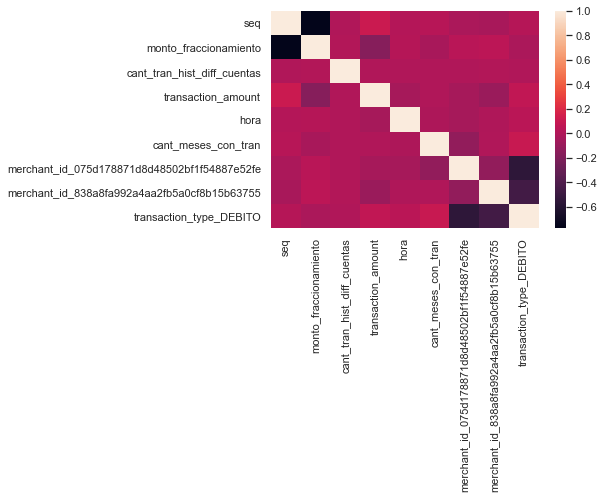

In [62]:
corplot=variables_consolidadas.corr().unstack().abs().reset_index()
sns.heatmap(variables_consolidadas.corr())

In [63]:
from sklearn.preprocessing import StandardScaler
## Estandarización #z = (x - u) / s
ss=StandardScaler()

In [64]:
variables_consolidadas[['transaction_amount','cant_meses_con_tran','cant_tran_hist_diff_cuentas','seq']]=\
            ss.fit_transform(variables_consolidadas[['transaction_amount','cant_meses_con_tran','cant_tran_hist_diff_cuentas','seq']])

* Identificación de correlaciones.
* La variable antagonica de debito corresponde al 0 que es credito (evitando multicolinealidad  y redundancia se elimina)

In [65]:
corplot[(corplot[0]>0.3) & (corplot[0]<1)]

,level_0,level_1,0
1,seq,monto_fraccionamiento,0.775907
9,monto_fraccionamiento,seq,0.775907
62,merchant_id_075d178871d8d48502bf1f54887e52fe,transaction_type_DEBITO,0.557930
71,merchant_id_838a8fa992a4aa2fb5a0cf8b15b63755,transaction_type_DEBITO,0.467298
78,transaction_type_DEBITO,merchant_id_075d178871d8d48502bf1f54887e52fe,0.557930
79,transaction_type_DEBITO,merchant_id_838a8fa992a4aa2fb5a0cf8b15b63755,0.467298


In [66]:
del variables_consolidadas['monto_fraccionamiento']

In [67]:
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV,train_test_split,cross_val_score,KFold,GridSearchCV

In [68]:
objetivo = consolidado["output"]
 
variables_consolidadas.columns= variables_consolidadas.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))

In [105]:
del variables_consolidadas['hora']

In [106]:
x_train, x_test, y_train, y_test = train_test_split(variables_consolidadas,objetivo, test_size=0.25,random_state=90)
#Entrenamiento y validación con relación 90:10
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.1, random_state=90)
print("Shape of x_train:",x_train.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of x_val:",x_val.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test:",y_test.shape)
print("Shape of y_val:",y_val.shape)

Shape of x_train: (2025000, 7)
Shape of x_test: (750000, 7)
Shape of x_val: (225000, 7)
Shape of y_train: (2025000,)
Shape of y_test: (750000,)
Shape of y_val: (225000,)


In [107]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
columns = x_train.columns
## Aplicando el balanceo de datos, solo a la data de entrenamiento
train_data_X,train_data_y=sm.fit_sample(x_train, y_train.values.ravel()) #bien
train_data_X = pd.DataFrame(data=train_data_X,columns=columns )
train_data_y= pd.DataFrame(data=train_data_y)

In [108]:
objetivo.value_counts(True)

0    0.874393
1    0.125607
Name: output, dtype: float64

* Modelo lógistico
* Con Stats models con el fin de interpretar dichas variables(coeficiente y su relación con la variable de salida)

* Usando el método stepwise forward identifico sólo las variables significativas

*** Stepwise regression is a way of selecting important variables to get a simple and easily interpretable model

In [73]:
log_reg = smf.logit("y_train ~  cant_meses_con_tran + transaction_amount+merchant_id_838a8fa992a4aa2fb5a0cf8b15b63755+merchant_id_075d178871d8d48502bf1f54887e52fe", data=x_train).fit()

Optimization terminated successfully.
         Current function value: 0.347840
         Iterations 6


Pr(Yi=1|Xi)=exp(β0+β1Xi+β2X2+β3X3)/1+exp(β0+β1Xi+β2X2+β3

In [74]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                y_train   No. Observations:              2025000
Model:                          Logit   Df Residuals:                  2024995
Method:                           MLE   Df Model:                            4
Date:                Mon, 13 Jun 2022   Pseudo R-squ.:                 0.07927
Time:                        00:06:49   Log-Likelihood:            -7.0438e+05
converged:                       True   LL-Null:                   -7.6502e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -2.0387      0.003   -777.121      0.000      -2.044      -2.034
cant_meses_con_tran                              0.1246      0.002     59.677      0.000       0.121       0.129
transaction_amount                               0.5958      0.002    335.456      0.000       0.592       0.599
merchant_id_838a8fa992a4aa2fb5a0cf8b15b63755    -0.3066      0.009    -33.400      0.000      -0.325      -0.289
merchant_id_075d178871d8d48502bf1f54887e52fe    -0.1937      0.007    -27.799      0.000      -0.207      -0.180
================================================================================================================
"""

### Las variables usadas del anterior modelo son todas significativas
* cant_meses_con_tran: Son la cantidad de transacciones en el historico.
* Interpretación de la varibale *"cant_meses_con_tran"* representa un coeficiente positivo, 0.1200 es el cambio esperado en el logit al aumentar una unidad las transacciones, manteniendo constantes las demás variables.
*  transaction_amount, el logaritmo de las probabilidades de el fraccionamiento (en comparación con el no fraccionamiento) aumentan en 0.5877. 

* Haber ido a un instituto de prestigio 2 frente a uno de prestigio 3 tenemos que restar los valores de los coeficientes. Así, -0.3112+0.4014= 0.0902, es más probable fraccionar la transacción si proviene del merchant_id_838a8fa992a4aa2fb5a0cf8b15b63755 versus el merchant_id_075d178871d8d48502bf1f54887e52fe.
* Interpretando el Pseudo R-squ. las variacones de las variables independientes no son capz de explicar las variables dependientes.
* El coeficiente estimado para la intersección (Intercept ) es el valor esperado del logaritmo de odds de que una entidad fraccione. los odds(chances) son muy bajos  e−2.04=0.1300 , lo que se corresponde con una probabilidad de obtener matrícula de  p=e0.1300/1+e0.1300=0.53 .


### XGBOOST
* Permite que las observaciones incluyan valores missing
* Permite el uso de GPUs
* Entrenamiento paralelizado (paraleliza algunas partes del algoritmo)
* Permite trabajar sobre matrices sparse
* Necesario one-hot-encoding de variables categóricas

In [76]:
from xgboost import XGBClassifier

* Sin smote

In [109]:
classi2=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
              learning_rate=0.25, max_delta_step=1, max_depth=2,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=50,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)
model2=classi2.fit(x_train, y_train)
y_hats = model2.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hats)) 

c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:56:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    655668
           1       0.95      0.58      0.72     94332

    accuracy                           0.94    750000
   macro avg       0.95      0.79      0.84    750000
weighted avg       0.94      0.94      0.94    750000



* Con smote
* Mejora considerablemente el recall

In [110]:
classi2=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
              learning_rate=0.25, max_delta_step=1, max_depth=2,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=50,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)
model2=classi2.fit(train_data_X, train_data_y)
y_hats = model2.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hats)) 

c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colu

[00:57:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.97      0.95      0.96    655668
           1       0.69      0.77      0.72     94332

    accuracy                           0.93    750000
   macro avg       0.83      0.86      0.84    750000
weighted avg       0.93      0.93      0.93    750000



In [79]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,accuracy_score,make_scorer

In [80]:
xgboost = XGBClassifier(random_state=10)
param_grid = {
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0],
        'n_estimators': [100,150]}

fit_params = {'eval_metric': 'mlogloss',
              'early_stopping_rounds': 10,
              'eval_set': [(x_val, y_val)]}



In [83]:
rs_clf = RandomizedSearchCV(xgboost, param_grid, n_iter=10,
                            n_jobs=-1, verbose=1, cv=3,
                            scoring='neg_log_loss', refit=False, random_state=42)

## Sin smote

In [81]:
rs_clf.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:14:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:14:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:14:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:15:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:15:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:16:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:16:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:19:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:19:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:19:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:20:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:20:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:20:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:24:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:26:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -0.69314718 -0.31399866 -0.63036628 -0.62796963         nan
 -0.33851278 -0.69314718 -0.1662364  -0.16760473]
  category=UserWarning,


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                   param_distributions={'colsample_bylevel': [0.4, 0.5, 0.6,
                                                              0.7, 0.8],
                               

In [82]:
best_score = rs_clf.best_score_
best_params = rs_clf.best_params_

In [87]:
classi=XGBClassifier(subsample= 0.6, reg_lambda=5.0, n_estimators= 100, min_child_weight= 3.0,
 max_depth= 15, learning_rate= 0.2, gamma= 1.0, colsample_bytree= 0.8, colsample_bylevel= 0.6)
model=classi.fit(x_train, y_train)
y_hats = model.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hats))

c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:46:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    655668
           1       0.93      0.60      0.73     94332

    accuracy                           0.94    750000
   macro avg       0.94      0.80      0.85    750000
weighted avg       0.94      0.94      0.94    750000



## Con smote

In [85]:
rs_clf.fit(train_data_X, train_data_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -0.69314718 -0.45643723 -0.67226294 -0.66292928         nan
 -0.52583619 -0.69314718 -0.30393728         nan]
  category=UserWarning,


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                   param_distributions={'colsample_bylevel': [0.4, 0.5, 0.6,
                                                              0.7, 0.8],
                               

In [86]:
best_score = rs_clf.best_score_
best_params = rs_clf.best_params_

In [89]:
best_params

{'subsample': 0.6,
 'reg_lambda': 5.0,
 'n_estimators': 100,
 'min_child_weight': 3.0,
 'max_depth': 15,
 'learning_rate': 0.2,
 'gamma': 1.0,
 'colsample_bytree': 0.8,
 'colsample_bylevel': 0.6}

In [111]:
classi=XGBClassifier(subsample= 0.6, reg_lambda=5.0, n_estimators= 100, min_child_weight= 3.0,
 max_depth= 15, learning_rate= 0.2, gamma= 1.0, colsample_bytree= 0.8, colsample_bylevel= 0.6)
model=classi.fit(train_data_X, train_data_y)
y_hats = model.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hats))

c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colu

[00:58:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.97      0.95      0.96    655668
           1       0.67      0.77      0.72     94332

    accuracy                           0.92    750000
   macro avg       0.82      0.86      0.84    750000
weighted avg       0.93      0.92      0.93    750000



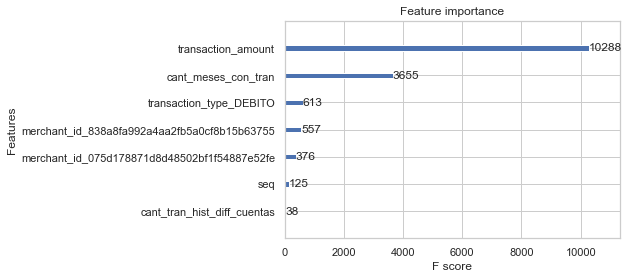

In [112]:
from xgboost import plot_importance
plot_importance(classi, max_num_features=20)
plt.show()

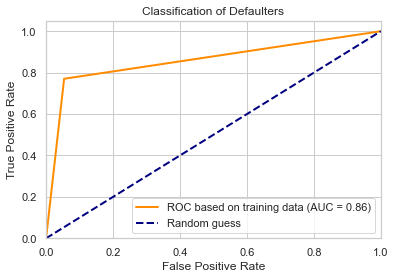

In [113]:
from sklearn.metrics import roc_curve, auc, accuracy_score
#%matplotlib inline
roc_vs = roc_curve(y_test, y_hats)
auc_vs = auc( roc_vs[0], roc_vs[1] )

plt.figure()
line_width = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange', lw=line_width,
         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

In [114]:
from matplotlib import pyplot

c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.64278	validation_0-error:0.12552	validation_0-logloss:0.60565	validation_1-auc:0.64318	validation_1-error:0.12578	validation_1-logloss:0.60330
[1]	validation_0-auc:0.87093	validation_0-error:0.10977	validation_0-logloss:0.52606	validation_1-auc:0.87101	validation_1-error:0.10978	validation_1-logloss:0.51443
[2]	validation_0-auc:0.87093	validation_0-error:0.05708	validation_0-logloss:0.43579	validation_1-auc:0.87101	validation_1-error:0.05706	validation_1-logloss:0.44193
[3]	validation_0-auc:0.87093	validation_0-error:0.05708	validation_0-logloss:0.37996	validation_1-auc:0.87101	validation_1-error:0.05706	validation_1-logloss:0.37926
[4]	validation_0-auc:0.87992	validation_0-error:0.05708	validation_0-logloss:0.33903	validation_1-auc:0.88022	validation_1-error:0.05706	validation_1-logloss:0.34017
[5]	validation_0-auc:0.88615	validation_0-error:0.05708	validation_0-logloss:0.29566	validation_1-auc:0.88637	validation_1-error:0.05706	validation_1-logloss:0.29950
[6]	

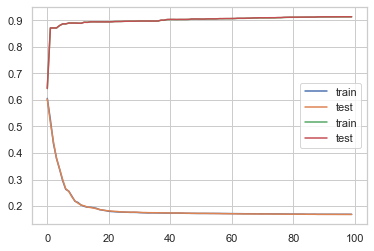

In [115]:
# define the datasets to evaluate each iteration
evalset = [(x_train, y_train), (x_test,y_test)]
# fit the model
eval_metric = ["auc","error","logloss"]

classi2.fit(x_train, y_train, eval_metric=eval_metric, eval_set=evalset)
# evaluate performance
yhat = classi2.predict(x_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = classi2.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
pyplot.plot(results['validation_0']['auc'], label='train')
pyplot.plot(results['validation_1']['auc'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [116]:
# import shap  # package used to calculate Shap values
# import matplotlib.pyplot as plt

# # Create object that can calculate shap values
# explainer = shap.TreeExplainer(classi)
# shap_values = explainer.shap_values(x_test)
# # Plot summary_plot
# shap.summary_plot(shap_values, x_test)

: 

In [1]:
### LightGBM
import lightgbm as lgb
clf = lgb.LGBMClassifier()
model=clf.fit(train_data_X, train_data_y)
y_pred=clf.predict(x_test)

NameError: name 'train_data_X' is not defined

In [ ]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

: 

In [ ]:
y_pred_train = clf.predict(x_train)

In [ ]:
y_pred=clf.predict(x_test)
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(x_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(x_test, y_test)))

Training set score: 0.9260
Test set score: 0.9259


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[621973  33695]
 [ 21916  72416]]


In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
#### roc
predictions = model.predict_proba(x_test)[:,1]
roc = roc_auc_score(y_test, predictions)
print("AUC: %.4f%% " % (roc * 100)) 

NameError: name 'roc_auc_score' is not defined

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [ ]:
param_test ={'num_leaves': sp_randint(5, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 11,12],
             'reg_lambda': [ 1, 5, 10, 20, 50]}

In [ ]:
clf = lgb.LGBMClassifier(max_depth=-1, random_state=90, silent=True, metric='None', n_jobs=4, n_estimators=1000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=10,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
random_search=RandomizedSearchCV(estimator = lgb.LGBMClassifier(),param_distributions=param_test,n_iter=4,scoring='f1_weighted',n_jobs=-1,cv=5,verbose=2,refit=True)
random_search.fit(train_data_X, train_data_y)

In [ ]:
print(random_search.best_estimator_)

In [ ]:
classi=lgb.LGBMClassifier(colsample_bytree=0.4651728978451084, min_child_samples=457,
               min_child_weight=1, num_leaves=45, reg_alpha=10, reg_lambda=10, subsample=0.8)

In [ ]:
model=classi.fit(train_data_X, train_data_y)

In [ ]:
y_hats = model.predict(x_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_hats))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(model.score(x_train, y_train)))

print('Test set score: {:.4f}'.format(model.score(x_test, y_test)))

In [ ]:
#%matplotlib inline
#Next we plot the ROC curve:
roc_vs = roc_curve(y_test, y_hats)
auc_vs = auc( roc_vs[0], roc_vs[1] )

plt.figure()
line_width = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange', lw=line_width,
         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of defaulters')
plt.legend(loc='lower right')
plt.show()

In [ ]:
pd.DataFrame({'Value':model.feature_importances_,'Feature':x_train.columns}).sort_values(by="Value",ascending=False).head(20)

### tabal pivot para mostrar la cantidad de eventos

In [264]:
a.filter(like='transaction_amount').sum(axis=1)

,key,date,transaction_amount_1,transaction_amount_2,transaction_amount_3
0,00015fd77a0f4d869bea31bb7244e375_00b954d48b4e5...,2021-07-21,594.445501,592.067719,NaN
1,00015fd77a0f4d869bea31bb7244e375_0fb03d04236e9...,2021-04-27,594.445501,178.333650,NaN
2,00015fd77a0f4d869bea31bb7244e375_13aec2e2781cc...,2021-03-30,594.445501,107.000190,NaN
3,00015fd77a0f4d869bea31bb7244e375_19be1051f8ef7...,2021-07-16,47.555640,594.445501,83.222370
4,00015fd77a0f4d869bea31bb7244e375_290ce859c4ace...,2021-03-23,594.445501,594.445501,NaN
5,00015fd77a0f4d869bea31bb7244e375_2ab891059dfd3...,2021-01-06,356.667301,142.666920,NaN
6,00015fd77a0f4d869bea31bb7244e375_2dc40e7df2a5b...,2021-03-13,594.445501,246.100438,NaN
7,00015fd77a0f4d869bea31bb7244e375_3727fe981bf3b...,2021-03-01,594.445501,428.000761,NaN
8,00015fd77a0f4d869bea31bb7244e375_3d7f6df80d0dd...,2021-11-04,594.445501,237.778200,NaN
9,00015fd77a0f4d869bea31bb7244e375_488db7993cd17...,2021-07-07,594.445501,594.445501,NaN
